In [16]:
from matplotlib import pyplot as plt
from PIL import Image
import pytesseract
import argparse
import cv2
import os
import numpy as np
import math
from shutil import copy
import imutils

In [17]:
src = 'pretrained_model/vie.traineddata'
dst = '/usr/share/tesseract/tessdata'
copy(src, dst)

'/usr/share/tesseract/tessdata/vie.traineddata'

In [18]:
def show_image(image):
    plt.imshow(image, cmap='gray')
    plt.show()

In [19]:
img = cv2.imread('../image/cccd/DTN_Shot.jpg', cv2.IMREAD_GRAYSCALE)

# thres, thres_img = cv2.threshold(img,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
print(img.shape)

(1811, 2561)


# Detect edge using houghline

#Scale the image, using houghline to detect line of edges and then apply perspecrive transform

# Testing, Showing, Tweaking Parameters For HoughLines

(1811, 2561, 3)


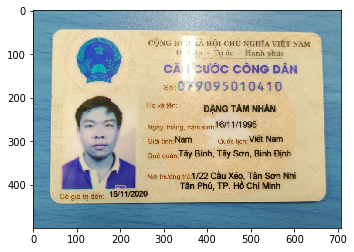

In [21]:
# TCT, NDMT
img_edge = cv2.imread('../image/cccd/DTN_Shot.jpg', cv2.IMREAD_COLOR)
print(img_edge.shape)
ratio = img_edge.shape[0] / 500.0
orig = img_edge.copy()
img_edge = imutils.resize(img_edge, height = 500)
show_image(img_edge)

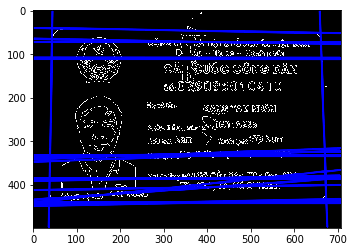

In [22]:
gray = cv2.cvtColor(img_edge, cv2.COLOR_BGR2GRAY)
gray = cv2.GaussianBlur(img_edge, (3, 3), 3)

dst = cv2.Canny(gray, 50, 100, None, 3)

# Copy edges to the images that will display the results in BGR
cdst = cv2.cvtColor(dst, cv2.COLOR_GRAY2BGR)

lines = cv2.HoughLines(dst, 1, np.pi / 180, 135, None, 0, 0)

if lines is not None:
    for i in range(0, len(lines)):
        rho = lines[i][0][0]
        theta = lines[i][0][1]
        a = math.cos(theta)
        b = math.sin(theta)
        x0 = a * rho
        y0 = b * rho
        pt1 = (int(x0 + 1000 * (-b)), int(y0 + 1000 * (a)))
        pt2 = (int(x0 - 1000 * (-b)), int(y0 - 1000 * (a)))
        cv2.line(cdst, pt1, pt2, (0, 0, 255), 3, cv2.LINE_AA)

# cv2_imshow(out)
# cv2_imshow(cdst)
show_image(cdst)

In [23]:
pts = []
for i in range(lines.shape[0]):
    (rho1, theta1) = lines[i, 0]
    m1 = -1 / np.tan(theta1)
    c1 = rho1 / np.sin(theta1)
    for j in range(i + 1, lines.shape[0]):
        (rho2, theta2) = lines[j, 0]
        m2 = -1 / np.tan(theta2)
        c2 = rho2 / np.sin(theta2)
        if np.abs(m1 - m2) <= 1e-8:
            continue
        x = (c2 - c1) / (m1 - m2)
        y = m1 * x + c1
        if 0 <= x < cdst.shape[1] and 0 <= y < cdst.shape[0]:
            pts.append((int(x), int(y)))

In [24]:
pts_corner = []
sorted_pts_x_axis = sorted(pts, key=lambda tup: tup[0])
sorted_pts_y_axis = sorted(pts, key=lambda tup: tup[1])

x_thres = (sorted_pts_x_axis[0][0] + sorted_pts_x_axis[-1][0]) / 2
y_thres = (sorted_pts_y_axis[0][1] + sorted_pts_y_axis[-1][1]) / 2

right = []
left = []

for i in range(len(pts)):
    if pts[i][0] <= x_thres:
        right.append(pts[i])
    else:
        left.append(pts[i])

In [25]:
centre_pt = (x_thres, y_thres)


def distance(pt1, pt2):
    pt1_ls = list(pt1)
    pt2_ls = list(pt2)

    return math.sqrt((pt1[0] - pt2[0]) ** 2 + (pt1[1] - pt2[1]) ** 2)

In [26]:
right_up = []
right_down = []
for i in range(len(right)):
    if right[i][1] <= y_thres:
        right_up.append(right[i])
    else:
        right_down.append(right[i])

thresh = -1
for i in range(len(right_up)):
    dist = distance(right_up[i], centre_pt)
    if dist > thresh:
        thresh = dist
        right_up_corner = right_up[i]
pts_corner.append(right_up_corner)

thresh = -1
for i in range(len(right_down)):
    dist = distance(right_down[i], centre_pt)
    if dist > thresh:
        thresh = dist
        right_down_corner = right_down[i]
pts_corner.append(right_down_corner)

In [27]:
left_up = []
left_down = []
for i in range(len(left)):
    if left[i][1] <= y_thres:
        left_up.append(left[i])
    else:
        left_down.append(left[i])

thresh = -1
for i in range(len(left_down)):
    dist = distance(left_down[i], centre_pt)
    if dist > thresh:
        thresh = dist
        left_down_corner = left_down[i]
pts_corner.append(left_down_corner)

thresh = -1
for i in range(len(left_up)):
    dist = distance(left_up[i], centre_pt)
    if dist > thresh:
        thresh = dist
        left_up_corner = left_up[i]
pts_corner.append(left_up_corner)

In [28]:
pts_np = np.array(pts_corner)
pts_use = pts_np[:,None] # We need to convert to a 3D numpy array with a singleton 2nd dimension
hull = cv2.convexHull(pts_use)

print(hull)

[[[673 443]]

 [[  3 440]]

 [[ 44  41]]

 [[660  52]]]


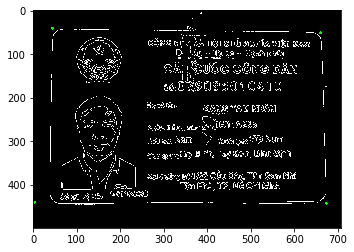

In [29]:
out2 = np.dstack([dst, dst, dst])
for pt in hull[:,0]:
    cv2.circle(out2, tuple(pt), 2, (0, 255, 0), 2)

show_image(out2)

In [30]:
def order_points(pts):
    # initialzie a list of coordinates that will be ordered
    # such that the first entry in the list is the top-left,
    # the second entry is the top-right, the third is the
    # bottom-right, and the fourth is the bottom-left
    rect = np.zeros((4, 2), dtype="float32")

    # the top-left point will have the smallest sum, whereas
    # the bottom-right point will have the largest sum
    s = pts.sum(axis=1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]

    # now, compute the difference between the points, the
    # top-right point will have the smallest difference,
    # whereas the bottom-left will have the largest difference
    diff = np.diff(pts, axis=1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]

    # return the ordered coordinates
    return rect

In [31]:
def four_point_transform(image, pts):
    # obtain a consistent order of the points and unpack them
    # individually
    rect = order_points(pts)
    (tl, tr, br, bl) = rect

    # compute the width of the new image, which will be the
    # maximum distance between bottom-right and bottom-left
    # x-coordiates or the top-right and top-left x-coordinates
    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    maxWidth = max(int(widthA), int(widthB))

    # compute the height of the new image, which will be the
    # maximum distance between the top-right and bottom-right
    # y-coordinates or the top-left and bottom-left y-coordinates
    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    maxHeight = max(int(heightA), int(heightB))

    # now that we have the dimensions of the new image, construct
    # the set of destination points to obtain a "birds eye view",
    # (i.e. top-down view) of the image, again specifying points
    # in the top-left, top-right, bottom-right, and bottom-left
    # order
    dst = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]], dtype="float32")

    # compute the perspective transform matrix and then apply it
    M = cv2.getPerspectiveTransform(rect, dst)
    warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))

    # return the warped image
    return warped

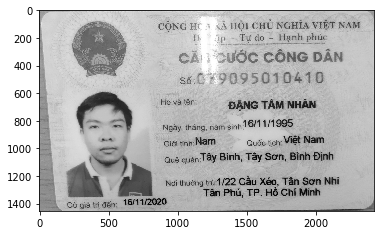

In [33]:
corner_arr = np.asarray(pts_corner, dtype = "float32")
warped = four_point_transform(orig, corner_arr * ratio)
warped = cv2.cvtColor(warped, cv2.COLOR_BGR2GRAY)
show_image(warped)

# Prepocessing image then apply tesseract

In [34]:
# Sharpened the images
def unsharp_mask(image, kernel_size, sigma, amount, threshold):
    """Return a sharpened version of the image, using an unsharp mask."""
    blurred = cv2.GaussianBlur(image, kernel_size, sigma)
    sharpened = float(amount + 1) * image - float(amount) * blurred
    sharpened = np.maximum(sharpened, np.zeros(sharpened.shape))
    sharpened = np.minimum(sharpened, 255 * np.ones(sharpened.shape))
    sharpened = sharpened.round().astype(np.uint8)
    if threshold > 0:
        low_contrast_mask = np.absolute(image - blurred) < threshold
        np.copyto(sharpened, image, where=low_contrast_mask)
    return sharpened

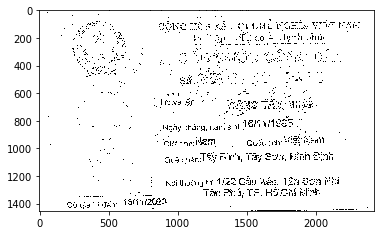

In [36]:
thres_img = cv2.adaptiveThreshold(warped,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,13,13)
show_image(thres_img)

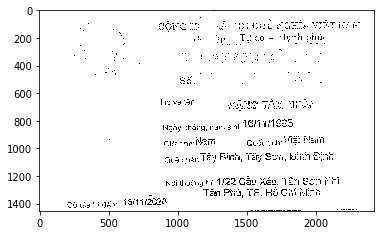

In [38]:
blur = cv2.medianBlur(thres_img,5)
show_image(blur)

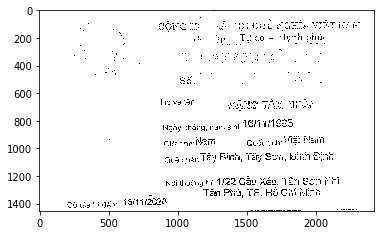

In [39]:
sharpened = unsharp_mask(blur, (5,5), 150, 50, 150)
show_image(sharpened)

# Calculate histogram then group them. Only used for part where most information reside and have no actual standard format. Ignore this part for now

In [40]:
def show_opencv_image_with_matplotlib(image_mat, dpi=250):
    nchannels = len(image_mat.shape)
    if(nchannels == 2):
        plt.imshow(image_mat, cmap = 'gray')
        plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
        plt.figure(dpi=dpi)
        plt.show()
    else:
        b_,g_,r_ = cv2.split(image_mat)
        image_mat_rgb = cv2.merge([r_,g_,b_])
        plt.imshow(image_mat_rgb)        
        plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
        plt.figure(dpi=dpi)
        plt.show()

In [41]:
# Define a function calculating histogram of a binary image
# by counting the number of non-zero pixels in each row/column
"""
    Args:
        img: a binary image after we highlight significant content       
        mode: mode of calculation for each row or column
    Returns:
        mhist: histogram vector which is calculated by this function
"""


def calculate_Histogram(img, mode='row'):
    # normalize image to [0,1]
    norm_img = img / np.max(img)
    mhist = None

    if mode == 'row':  # calculate histogram for each row
        mhist = np.zeros((img.shape[0]), dtype="uint8")
        for i in range(img.shape[0]):
            mhist[i] = np.sum(img[i, :])

    elif mode == 'column':  # calculate histogram for column
        mhist = np.zeros((img.shape[1]), dtype="uint8")
        for i in range(img.shape[1]):
            mhist[i] = np.sum(img[:, i])

    return mhist

In [42]:
# Display a function visualizing histogram map calculated by the above function
"""
    Args:
        hist: histogram map which is calculated by the above function
        mode: mode of displaying for row or column histogram
"""


def draw_histogram(hist, mode='row', dpi=80, figsize=None, hist_threshold=None):
    if not hist_threshold == None:
        for idx in range(hist.shape[0]):
            if hist[idx] < hist_threshold:
                hist[idx] = 0

    idx = np.arange(hist.shape[0])
    plt.style.use('dark_background')
    if mode == 'row':  # display histogram for each row
        width = [1.0]
        plt.figure(dpi=dpi, figsize=figsize)
        plt.barh(idx, np.flip(hist), height=width, color='white')
        plt.show()
    elif mode == 'column':  # display histogram for column
        width = [1.]
        plt.figure(dpi=dpi, figsize=figsize)
        plt.bar(idx, hist, width=width, color='white')
        plt.show()

In [43]:
# Define a function groupping consecutive rows/columns 
# into segments by examining histogram calculated above
"""
    Args:   
        hist: row-histogram vector which is calculated the above function with mode 'row'
    Returns:
        content_segment: a list containing elements which are groups of consecutive rows/columns
                         each segment described by (begin_idx, end_idx+1)
"""


def group_consecutive_hist_into_segments(hist, hist_threshold):
    # Remove noise = Mark row i:
    #  is_content_line[i] = 1 if hist[i]>=45
    #  is_content_line[i] = 0, otherwise
    is_content_line = (hist >= hist_threshold).astype(int)

    # Group lines containing content into segments
    # and save begin/end idx of each content segment
    beg = end = -1
    content_segment = list()
    for i in range(is_content_line.shape[0]):
        if is_content_line[i] == 1:
            # find begin idx
            if i == 0:
                beg = i
            elif is_content_line[i - 1] == 0:
                beg = i

                # find end idx
            if i == is_content_line.shape[0] - 1:
                end = i + 1
            elif is_content_line[i + 1] == 0:
                end = i + 1

        # If find 2 beg/end points, add segment
        if (beg != -1) and (end != -1):
            content_segment.append((beg, end))
            beg = end = -1
    return content_segment

In [44]:
# Define a function groupping nearby segments
# into sections by examining histogram calculated above
"""
    Args:    
        content_segment: a list containing elements which are groups of consecutive rows
        hist: histogram vector calculated w.r.t to row/column
        threshold_distance: minimum distance between 2 sections
        threshold_segment_hist: minimum total hist of a section
    Returns:
        section: a list containing sections which are groups of consecutive rows/columns
                 each section described by (begin_idx, end_idx+1)        
"""


def form_sections_from_segments(content_segment, hist, threshold_distance=None, threshold_segment_hist=None):
    # Calculate the height of each content_segment
    segment_height = [content_segment[i][1] - content_segment[i][0] for i in range(len(content_segment))]

    section = list()
    current_sect = (-1, -1)
    for idx, segment in enumerate(content_segment):
        if current_sect[0] == -1 and current_sect[1] == -1:
            current_sect = (segment[0], segment[1])
            continue

        # Calculate distance from segment to current section
        distance = segment[0] - current_sect[1]

        # Calculate total content pixel of segment
        segment_hist = np.sum(hist[segment[0]:segment[1]])

        if distance < threshold_distance or segment_hist < threshold_segment_hist:
            # if segment is too small or too close to a section
            # then merge current segment to current part
            current_sect = (current_sect[0], segment[1])
        else:
            # otherwise, if segment is large enough
            # save previous section and form a new section with current segment
            section.append(current_sect)
            current_sect = (segment[0], segment[1])

        # save the last section
        if idx == len(content_segment) - 1:
            section.append(current_sect)
    return section

In [45]:
# Define a function to split each row (separated above) into 4 questions
"""
    Args:
        row_img: regions of interest (ROI) of each row
                 that contains 4 in-line questions 
    Returns:
        question_sements: a list containing question segments 
                          each question described by (begin_idx, end_idx+1) in image     
"""


def split_question_from_each_row(row_img):
    vertical_hist = calculate_Histogram(row_img, mode='column')
    # draw_histogram(vertical_hist, mode='column',figsize=(15,7))

    segments = group_consecutive_hist_into_segments(vertical_hist)
    questions_segment_idx = form_sections_from_segments(segments, vertical_hist, 25, 100)

    return questions_segment_idx

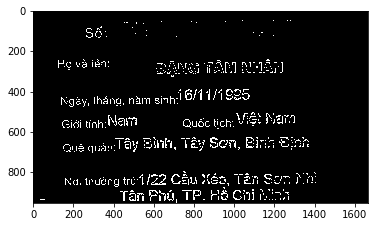

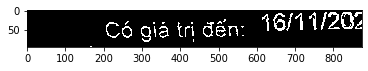

In [47]:
# If some information is missing, changing the ratio
bin_img = ~sharpened

ratio_x_1 = 2.7/8.6
ratio_x_2 = 3.1/8.6
ratio_y_1 = 1.5/5.4
ratio_y_2 = 4.9/5.4

ratio_y_3 = 5.05/5.4

part_1 = bin_img[int(bin_img.shape[0]*ratio_y_1):int(bin_img.shape[0]*ratio_y_3),
                 int(bin_img.shape[1]*ratio_x_1):]

part_2 = bin_img[int(bin_img.shape[0]*ratio_y_3):,
                 :int(bin_img.shape[1]*ratio_x_2)]

show_image(part_1)
show_image(part_2)

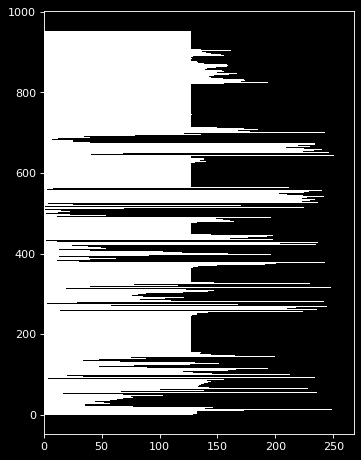

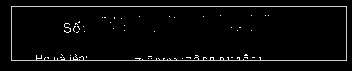

<Figure size 1500x1000 with 0 Axes>

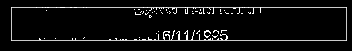

<Figure size 1500x1000 with 0 Axes>

<Figure size 1500x1000 with 0 Axes>

<Figure size 1500x1000 with 0 Axes>

<Figure size 1500x1000 with 0 Axes>

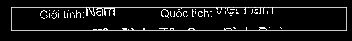

<Figure size 1500x1000 with 0 Axes>

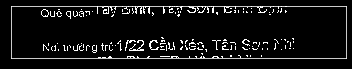

<Figure size 1500x1000 with 0 Axes>

<Figure size 1500x1000 with 0 Axes>

In [48]:
# cv2_imshow(~part_2)

# Calculate row-wise histogram
histogram_per_row = calculate_Histogram(~part_1, mode='row')

# Visualize histogram in row
draw_histogram(histogram_per_row, mode='row',figsize=(5,7))

# Group histogram of consecutive rows in form of segments
content_segment = group_consecutive_hist_into_segments(histogram_per_row, 3)

# Display regions of interest (ROI) for segments
for idx, sect in enumerate(content_segment):        
    # Crop a corresponding region on threshold image
    image_section = part_1[sect[0]:sect[1],:]
    show_opencv_image_with_matplotlib(image_section)

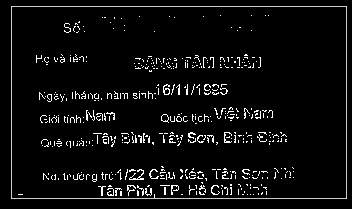

<Figure size 1500x1000 with 0 Axes>

In [49]:
# Group nearby/small segment into big sections
# threshold_distance = thres_img.shape[0] * 0.00735

threshold_distance = sharpened.shape[0] * 0.00735
row_section_idx = form_sections_from_segments(content_segment,
                                              histogram_per_row,
                                              threshold_distance=threshold_distance, 
                                              threshold_segment_hist=1000)

# Save regions of interest (ROI) of sections in a list and display them
row_section = list()
for idx, sect in enumerate(row_section_idx):        
    # Crop a corresponding region on threshold image
    image_section = part_1[sect[0]:sect[1],:]
    row_section.append(image_section)
    show_opencv_image_with_matplotlib(image_section)

In [50]:
# For part 2 just simply apply tesseract provided the image is clear enough
text = pytesseract.image_to_string(~part_2, lang = 'vie')
print(text)

› Có gìảtrịđẽnz 16/11/232
